In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import pandas as pd

2023-12-09 00:09:41.302931: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 00:09:41.329297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 00:09:41.329326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 00:09:41.329354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 00:09:41.335215: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


## Load Data from Text File

In [3]:
train_data = np.loadtxt("../../data/ttbar100k/train_data.txt")
train_edges = np.loadtxt("../../data/ttbar100k/train_edges.txt")

x_train = train_data[:,0:3]
y_train = train_data[:,3]

test_data = np.loadtxt("../../data/ttbar100k/test_data.txt")
test_edges = np.loadtxt("../../data/ttbar100k/test_edges.txt")

x_test = test_data[:,0:3]
y_test = test_data[:,3]

## Convert Edges to Zero based Indicies

*After the padding in the data was removed, the unique jetID used to create edges became sparse. We need to convert the unique jetID back into zero based indicies.*

In [4]:
idx_train = np.array(train_data[:, -1], dtype=np.int32) # Reading node-ids
idx_map_train = {j: i for i, j in enumerate(idx_train)} # Creating index for nodes to map it in adjacency matrix   
edges_train = np.array(list(map(idx_map_train.get, train_edges.flatten())),dtype=np.int32).reshape(train_edges.shape) # Mapping node-ids in the edge list to the index

idx_test = np.array(test_data[:, -1], dtype=np.int32) # Reading node-ids
idx_map_test = {j: i for i, j in enumerate(idx_test)} # Creating index for nodes to map it in adjacency matrix   
edges_test = np.array(list(map(idx_map_test.get, test_edges.flatten())),dtype=np.int32).reshape(test_edges.shape) # Mapping node-ids in the edge list to the index

## Constuct Graph Info 

*Node Features, Edges, and Edge Weights*

In [5]:
#Construct graph info

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges_train = edges_train.T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges_train.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(train_data[:,0:3], dtype=tf.dtypes.float32)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges_train, edge_weights)

print("Edges shape:", edges_train.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 3050108)
Nodes shape: (990891, 3)


2023-12-09 00:09:44.259572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## Create Simple, Configurable Feed Forward Network

*The FFN will be used for pre-processing and post-processing layers. It will also be used to perform permutation invariant message passing during the Graph Convolution Layer.*

In [6]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [7]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits", activation="sigmoid")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

num_features = len(node_features[0])
hidden_units_1 = [16, 32, 32, 16]
dropout_rate_1 = 0.25
num_classes_1 = 1 

baseline_model = create_baseline_model(hidden_units_1, num_classes_1, dropout_rate_1)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 3)]                  0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 16)                   2524      ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 16)                   2784      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 16)                   0         ['ffn_block1[0][0]',   

## Create Graph Convolution Layer

*Graph Convolution Layers follow from the premise of deep sets: https://arxiv.org/abs/1703.06114. The following theorem states how to construct a valid set function using two transformations: $\phi$ and $\rho$. Since MLP are considered universal function approximators, $\phi$ and $\rho$ can be modeled as neural networks.*

> **Theorem 2** A function f (X) operating on a set X having elements from a countable universe, is a
valid set function, i.e., invariant to the permutation of instances in X, iff it can be decomposed in the
form ρ (∑
x∈X φ(x)), for suitable transformations φ and ρ.

*Message passing in graph neural networks is performed using the valid set funcion shown below. The node representation in the k-1 graph layer, $x_i^{(k-1)}$, will be aggregated with neighboring nodes, $x_j^{(k-1)}$, along with (optional) edge features $e_{j,i}$ using MLP $\phi^{(k)}$. Now, $\forall j \in \mathcal{N}(i)$ we perform a permutation invariant operation (sum, mean, max) on the outputs of $\phi^{(k)}$. Then the MLP $\rho^{(k)}$ will use the result of the permutation invariant vector along with the node representation, $x_i^{(k-1)}$, to compute the updated node embedding in the k graph layer, $x_i^{(k)}$.*

$$\mathbf{x}_i^{(k)} = \rho^{(k)} \left( \mathbf{x}_i^{(k-1)}, \bigoplus_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),$$

In [8]:
# Graph convolution layer
# source: https://keras.io/examples/graph/gnn_citations/
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


## Construct GNN Node Classifier

*This is the 'driver' function that links together pre-processing, graph convolution layer, post-processing layer, and the final classification layer.*

In [9]:
# Defines the model structure and performs classification on nodes
# source: https://keras.io/examples/graph/gnn_citations/
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        #self.conv2 = GraphConvLayer(
        #    hidden_units,
        #    dropout_rate,
        #    aggregation_type,
        #    combination_type,
        #    normalize,
        #    name="graph_conv2",
        #)
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits", activation="sigmoid")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        #x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        #x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


## Initialize the GNN Model

*Define model parameters, initialize GNNNodeClassifier object, and test the model by passing a list of node indicies, [1, 10, 100], to get the output score of the model. Notice the model is untrained, so these values are insignificant.*

In [10]:
hidden_units = [16, 32, 32, 16]
learning_rate = 0.0005
dropout_rate = 0.25
num_epochs = 5
batch_size = 1024
num_classes = 1     # Binary Classification [0,1]

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1,10,100]))

gnn_model.summary()


GNN output shape: tf.Tensor(
[[0.4825223 ]
 [0.49287522]
 [0.49017018]], shape=(3, 1), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (990891, 16)              2524      
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 postprocess (Sequential)    (990891, 16)              2784      
                                                                 
 logits (Dense)              multiple                  17        
                                                                 
Total params: 11213 (43.80 KB)
Trainable params: 10439 (40.78 KB)
Non-trainable params: 774 (3.02 KB)
___________________________________________________

## Define the Training Loop

*Compile the model with the optimizer, loss function, and training metric. Implement early stoppting to prevent overtraining. Finally, train the model using model.fit().*

In [11]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=5, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
        shuffle=True,
        use_multiprocessing=True,
    )

    return history

In [12]:
x_train_idx = np.arange(len(y_train))
history = run_experiment(gnn_model, x_train_idx, y_train)

Epoch 1/5


2023-12-09 00:09:51.802346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa948225340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-09 00:09:51.802373: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-09 00:09:51.805324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-09 00:09:51.825281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-09 00:09:51.877437: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


823/823 [==============================] - 244s 288ms/step - loss: 0.6642 - acc: 0.6015 - val_loss: 0.6091 - val_acc: 0.6584
Epoch 2/5
823/823 [==============================] - 236s 286ms/step - loss: 0.6337 - acc: 0.6338 - val_loss: 0.6076 - val_acc: 0.6606
Epoch 3/5
823/823 [==============================] - 236s 287ms/step - loss: 0.6286 - acc: 0.6368 - val_loss: 0.6083 - val_acc: 0.6617
Epoch 4/5
823/823 [==============================] - 236s 286ms/step - loss: 0.6258 - acc: 0.6385 - val_loss: 0.6098 - val_acc: 0.6607
Epoch 5/5
823/823 [==============================] - 236s 287ms/step - loss: 0.6239 - acc: 0.6392 - val_loss: 0.6074 - val_acc: 0.6633


In [13]:
history_simple_NN = run_experiment(baseline_model, x_train, y_train)

Epoch 1/5
823/823 [==============================] - 20s 16ms/step - loss: 0.7192 - acc: 0.5895 - val_loss: 0.6171 - val_acc: 0.6575
Epoch 2/5
823/823 [==============================] - 13s 15ms/step - loss: 0.6370 - acc: 0.6304 - val_loss: 0.6120 - val_acc: 0.6595
Epoch 3/5
823/823 [==============================] - 13s 16ms/step - loss: 0.6307 - acc: 0.6346 - val_loss: 0.6097 - val_acc: 0.6636
Epoch 4/5
823/823 [==============================] - 13s 16ms/step - loss: 0.6280 - acc: 0.6365 - val_loss: 0.6095 - val_acc: 0.6633
Epoch 5/5
823/823 [==============================] - 13s 16ms/step - loss: 0.6263 - acc: 0.6375 - val_loss: 0.6085 - val_acc: 0.6625


## Display Learning Curves

In [14]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "validation"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "validation"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


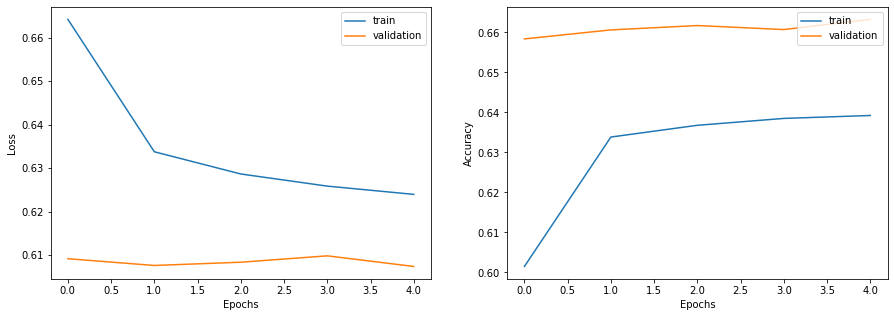

In [15]:
display_learning_curves(history)

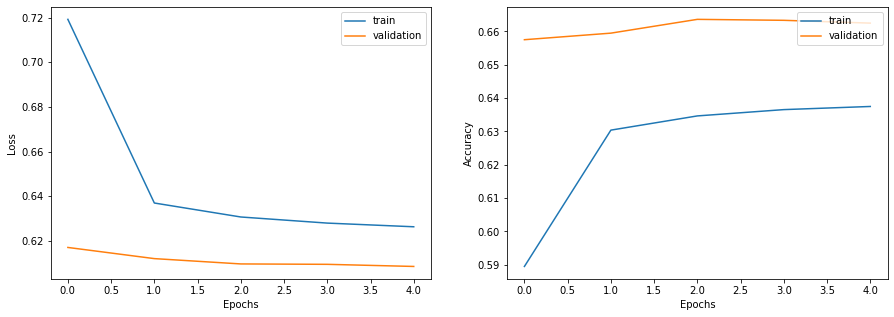

In [16]:
display_learning_curves(history_simple_NN)

## Calulate ROC Curves, AUC and F1 score

*ROC Curves show TPR vs FPS. AUC is the area under the ROC curve (higher is better). $F1 = \frac{2 * precision * recall}{precision + recall} = \frac{2*tpr}{2*tpr+fpr*fnr}$ (higher is better). To calculate ROC Curves, x_test is used, which a fraction of the dataset that the model has not seen before.*

In [17]:
#Construct graph info

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges_test = edges_test.T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges_test.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(test_data[:,0:3], dtype=tf.dtypes.float32)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges_train, edge_weights)

gnn_model.node_features = node_features
gnn_model.edges = edges_test
gnn_model.edge_weights = edge_weights

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

x_test_idx = np.arange(len(y_test))

y_pred = gnn_model.predict(x_test_idx).ravel()
y_true = y_test

y_pred_simple = baseline_model.predict(x_test).ravel()
y_true_simple = y_test

10333/10333 [==============================] - 21s 2ms/step


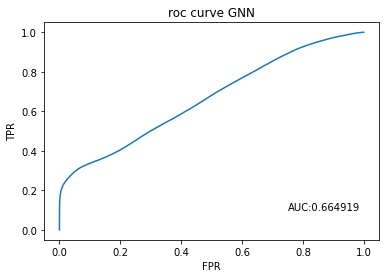

In [19]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
AUC = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)
plt.title("roc curve GNN")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(0.75,0.1,"AUC:"+str(round(AUC,6)))
plt.show()

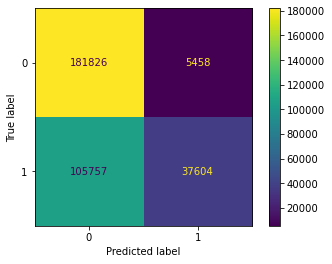

F1 Score:  0.40342661581457223


In [20]:
threshold = 0.5
y_pred[y_pred>=threshold]=1
y_pred[y_pred<threshold]=0
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

F1 = f1_score(y_true, y_pred)
print("F1 Score: ", F1)

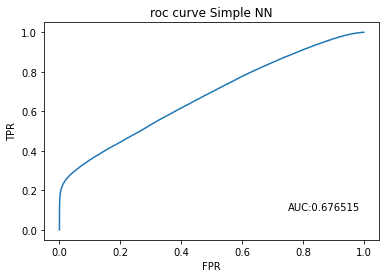

In [21]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_simple, y_pred_simple)
AUC = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)
plt.title("roc curve Simple NN")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.text(0.75,0.1,"AUC:"+str(round(AUC,6)))
plt.show()

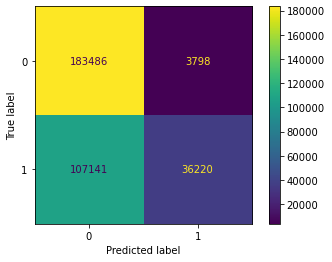

F1 Score:  0.395028874625775


In [22]:
threshold = 0.5
y_pred_simple[y_pred_simple>=threshold]=1
y_pred_simple[y_pred_simple<threshold]=0
cm = confusion_matrix(y_true, y_pred_simple)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

F1 = f1_score(y_true, y_pred_simple)
print("F1 Score: ", F1)